In [243]:
import json, os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import re

In [244]:
# '1a-basic-flow' yes
# '1b-basic-flow' yes
# '2-expr-binary-ops' yes
# '3a-expr-func-calls' yes
# '3b-expr-func-calls' yes
# '4a-conds-branching' yes
# '4b-conds-branching' yes
# '5a-loops-unfolding' yes
# '5b-loops-unfolding' yes
# '5c-loops-unfolding' yes
# '6a-sanitization' yes
# '6b-sanitization' yes
# '7-conds-implicit' yes
# '8-loops-implicit' yes
# '9-regions-guards' missing one sanitizer due to implicit flow in second loop

TEST_SlICE = '9-regions-guards'

In [245]:
with open(os.path.join('testSlices', TEST_SlICE + '.json')) as json_file:
    slices = json.load(json_file)
# '5b-loops-unfolding'

with open(os.path.join('testPatterns', TEST_SlICE + '.patterns.json')) as json_file:
    patterns = json.load(json_file)

Initialize Classes

In [246]:
class Stmt_Expression():
    def __init__(self, expr):
        self.expr = expr
    
    def __repr__(self):
        return f"Stmt_Expression({self.expr})"

class Expr_Assign():
    def __init__(self, var, list_expr):
        self.var = var
        #var.value = [repr(expr) for expr in list_expr]
        self.list_expr = list_expr
    def __repr__(self):
        str_list_expr = ", ".join(str(expr) for expr in self.list_expr)
        return f"{self.var} = {str_list_expr}"

class Expr_FuncCall():
    def __init__(self, name, args=[]):
        self.name = name
        self.args = args
    def __str__(self):
        str_args = ", ".join(str(arg) for arg in self.args)
        return f"{self.name}({str_args})"
    def __repr__(self):
        return f"{self.name}" #()"

class Stmt_While():
    def __init__(self, conditions, whileBlock):
        self.conditions = conditions
        self.whileBlock = whileBlock
    def __repr__(self) -> str:
        str_whileBlock = ";\n".join(f'\t{stmt}' for stmt in self.whileBlock)
        str_while = f"while({self.conditions})\n[{str_whileBlock}]"
        return str_while


class Stmt_If_Else():
    def __init__(self, conditions, ifBlock, elseIfs, elseBlock):
        self.conditions = conditions 
        self.ifBlock = ifBlock
        self.elseIfs = elseIfs
        self.elseBlock = elseBlock
    def __repr__(self):
        str_ifBlock = ";\n".join(f'\t{stmt}' for stmt in self.ifBlock)
        str_stmt_if = f"if({self.conditions})[\n{str_ifBlock}]"
        if len(self.elseIfs) > 0:
            str_stmt_if += f"\nelseIf[\n\t{self.elseIfs}]"
        if len(self.elseBlock) > 0:
            str_elseBlock = ";\n".join(f'\t{stmt}' for stmt in self.elseBlock)
            str_stmt_if += f"\nelse[\n{str_elseBlock}]"
        return str_stmt_if

class Expr_Variable():
    def __init__(self, name):
        self.name = name
        self.value = [] #set()
    def __repr__(self):
        return f"${self.name}"
    def __eq__(self, other):
        # Check if the other object is an Assignment and has the same left and right values
        if isinstance(other, Expr_Variable) and self.name == other.name and any(val in self.value for val in other.value):
            return True
        return False
    def __hash__(self):
        # Return a unique and immutable value based on the left and right values
        return hash(self.name)

class Constant():
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return f"Constant(value={self.value})"
    def __repr__(self):
        return f'"{self.value}"'

class Stmt_Nop():
    def __init__(self, value):
        self.value = value
    def __repr__(self):
        return f"Nop(value={self.value})"
        
class Expr_BinaryOp_Concat():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}, {self.right}"

class Expr_BinaryOp_Greater():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}>{self.right}"

class Expr_BinaryOp_Smaller():
    def __init__(self, left, right):
        self.left = left
        self.right = right
    def __repr__(self):
        return f"{self.left}<{self.right}"

class Program():
    def __init__(self, steps):
        self.steps = steps
    def __repr__(self):
        str_steps = '\n'.join(f'\t{idx}. {step}' for idx, step in enumerate(self.steps))
        return f'\n{str_steps}\n'

Recusive Function to convert the input slices into class objects

In [247]:
def create_program(slices):
    def flatten(lst):
        flat_list = []
        for item in lst:
            if isinstance(item, list):
                flat_list.extend(flatten(item))
            else:
                flat_list.append(item)
        return flat_list
    
    def process_json(obj):
        if isinstance(obj, dict):
            if obj["nodeType"] == 'Stmt_While':
                conditions = flatten([process_json(obj["cond"])])
                whileBlock = flatten([process_json(stmt) for stmt in obj["stmts"]])
                return Stmt_While(conditions, whileBlock)
            if obj["nodeType"] == 'Stmt_If':
                conditions = flatten([process_json(obj["cond"])])
                ifBlock = flatten([process_json(stmt) for stmt in obj["stmts"]])
                elseIfs = flatten([process_json(elifs) for elifs in obj["elseifs"]])
                elseBlock = [] if obj["else"] is None else [process_json(stmt) for stmt in obj["else"]["stmts"]]
                return Stmt_If_Else(conditions, ifBlock, elseIfs, elseBlock)
            if obj["nodeType"] == 'Stmt_Expression':
                return process_json(obj["expr"])
            if obj["nodeType"] == "Expr_Assign":
                var = process_json(obj["var"])
                list_expr = flatten([process_json(obj["expr"])])
                return Expr_Assign(var, list_expr)
            if obj["nodeType"] == "Expr_FuncCall":
                name = obj["name"]["parts"][0]
                args = flatten([process_json(arg) for arg in obj["args"]])
                return Expr_FuncCall(name, args)
            if obj["nodeType"] == "Expr_BinaryOp_Concat" \
                or obj["nodeType"] == "Expr_BinaryOp_Plus":
                left = process_json(obj["left"])
                right = process_json(obj["right"])
                return flatten([left, right])
            if obj["nodeType"] == "Expr_BinaryOp_Greater":
                left = process_json(obj["left"])
                right = process_json(obj["right"])
                return flatten([left, right]) #Expr_BinaryOp_Greater(left, right)
            if obj["nodeType"] == "Expr_BinaryOp_Smaller":
                left = process_json(obj["left"])
                right = process_json(obj["right"])
                return flatten([left, right]) #Expr_BinaryOp_Smaller(left, right)
            if obj["nodeType"] == "Expr_BinaryOp_Equal":
                left = process_json(obj["left"])
                right = process_json(obj["right"])
                return flatten([left, right])
            if obj["nodeType"] == "Expr_BinaryOp_NotEqual":
                left = process_json(obj["left"])
                right = process_json(obj["right"])
                return flatten([left, right])
            if obj["nodeType"] == "Arg":
                return process_json(obj["value"])
            if obj["nodeType"] == "Expr_Variable":
                return Expr_Variable(obj["name"])
            if obj["nodeType"] == "Scalar_String":
                return Constant(obj["value"])
            if obj["nodeType"] == "Scalar_LNumber":
                return Constant(obj["value"])
            if obj["nodeType"] == "Stmt_Nop":
                return Stmt_Nop("Nop")
            print(obj["nodeType"])
            return None
        elif isinstance(obj, list):
            steps = [process_json(step) for step in obj]
            return Program(steps)
        else:
            # this is for error catching :)
            print(obj)
            return None

    return process_json(slices)
    # Process the JSON object

program = create_program(slices)

Print the program in a readable format

In [248]:
def flatten(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list

def recusrive_post_process(obj, stack={1:{}}, depth=1):
    if isinstance(obj, Program):
        for step in obj.steps:
            recusrive_post_process(step, stack, depth)
    if isinstance(obj, Expr_Assign):
        for expr in obj.list_expr:
            recusrive_post_process(expr, stack, 0) #depth-1)
        if repr(obj.var) in stack[depth]:
            stack[depth][repr(obj.var)].extend([obj.list_expr[0]])
        else:
            stack[depth][repr(obj.var)] = [obj.list_expr[0]]
        obj.var.value.extend([obj.list_expr[0]])
        for level in stack:
            if int(level) > int(depth):
                obj.var.value.extend([stack.get(level, {}).get(repr(obj), [])])
    if isinstance(obj, Expr_FuncCall):
        for arg in obj.args:
            recusrive_post_process(arg, stack, 0) #depth)
    if isinstance(obj, Expr_Variable):
        for level in reversed(stack):
            if int(level) >= int(depth):
                obj.value.extend(flatten([stack.get(level, {}).get(repr(obj), [])]))
    if isinstance(obj, Stmt_If_Else):
        recusrive_post_process(obj.conditions, stack, depth)
        stack[depth+1] = {}
        recusrive_post_process(obj.ifBlock, stack, depth+1)
        recusrive_post_process(obj.elseBlock, stack, depth+1)
    if isinstance(obj, Stmt_While):
        recusrive_post_process(obj.conditions, stack, depth)
        stack[depth+1] = {}
        recusrive_post_process(obj.whileBlock, stack, depth+1)
        #stack[depth+2] = {}
        recusrive_post_process(obj.whileBlock, stack, depth+1) 
    if isinstance(obj, list):
        for item in obj:
            recusrive_post_process(item, stack, depth)
    
recusrive_post_process(program)

In [249]:
program


	0. $a = b(Constant(value=ola))
	1. $c = d(Constant(value=oi))
	2. $i = Constant(value=)
	3. while([$a, ""])
[	$f = s($c, Constant(value=0), Constant(value=1));
	if([$f, "a"])[
	$i = $i, Constant(value=')]
else[
	$i = $i, Constant(value= )];
	$a = s($a, Constant(value=1))]
	4. z(Constant(value=0), $i)
	5. Nop(value=Nop)

In [250]:
class CustomGraph:
    def __init__(self, name):
        self.nodes = set([])
        self.edges = []
        self.name = name

    def add_node(self,node):
        self.nodes.add(node)
        
    def remove_node(self,node):
        self.nodes.remove(node)

    def add_edge(self, firstNode, secondNode, edge_type="explicit"):
        self.nodes.add(firstNode)
        self.nodes.add(secondNode)
        self.edges.append((firstNode,secondNode, edge_type))

    def remove_edge(self, firstNode, secondNode):
        self.edges.remove((firstNode, secondNode))

    def has_node(self, node):
        return node in self.nodes

    # This function replaces evalMode and is supposed to improve generalization
    # There might be several nodes which match the string, so we need to return all of them
    def get_possible_nodes_from_repr(self, node):
        output = []
        for n in self.nodes:
            if str(node) == repr(n):
                output.append(n)
        return output

    def in_edges(self, node):
        edgesFound = []
        for edge in self.edges:
            if node in edge:
                edgesFound.append(edge)
        return edgesFound

    def successors(self, node, implicit=False):
        successors = []
        for pair in self.edges:
            # If implicit flag is set skip the edge
            if not implicit and pair[2] == 'implicit':
                continue
            #if evalMode:
            #    if repr(pair[0]) == str(node):
            #        successors.append(repr(pair[1]))
            #else:
            if pair[0] == node:
                successors.append(pair[1])
        return successors

    def predecessors(self, node, implicit=False):
        successors = []
        for pair in self.edges:
            # If implicit flag is set skip the edge
            if not implicit and pair[2] == 'implicit':
                continue 
            #if evalMode:
            #    if repr(pair[1]) == str(node):
            #        successors.append(repr(pair[0]))
            #else:
            if pair[1] == node:
                successors.append(pair[0])
        return successors
    
    def add_edges_from(self, edges):
        for edge in edges:
            if edge not in self.edges:
                self.nodes.add(edge[0])
                self.nodes.add(edge[1])
                self.edges.append(edge)

    def __repr__(self):
        return f"{self.name}"

Recusively create a graph based on the program

In [251]:
codeBlockCounter = 1

# Function to recursively find all assignments in the AST
def create_graph(node, programGraph, graph):
    global codeBlockCounter

    if isinstance(node, Expr_Assign):
        #if graph.has_node(node.var):
            # If the variable isn't referenced anywhere, it is overwritten
        #    if len(graph.successors(node.var)) == 0:
        #        for u, v in list(graph.in_edges(str(node.var))):
        #            graph.remove_edge(u, v)
        #            graph.remove_node(u)

        for expr in node.list_expr:
            if isinstance(expr, Expr_FuncCall):
                graph.add_edge(expr, node.var)
                create_graph(expr, programGraph, graph)
            if isinstance(expr, Constant):
                graph.add_edge(expr, node.var)
            if isinstance(expr, Expr_Variable):
                graph.add_edge(expr, node.var)

    if isinstance(node, Expr_FuncCall):
        for arg in node.args:
            graph.add_edge(arg, node)
            create_graph(arg, programGraph, graph)

    if isinstance(node, Stmt_If_Else):
        #validate if there is assignment in the if condiction (it is possible!)
        create_graph(node.conditions, programGraph, graph)
        
        #we generate a code block for if the statement is true
        codeBlockCounter += 1
        new_ifGraph = CustomGraph(f"ifcodeBlock#{codeBlockCounter}")
        programGraph.add_edge(graph, new_ifGraph)
        # To detect implcit flows which are encoded in conditions, we need to
        # link all conditions to all assigned variables
        # TODO: Extend this to functions
        for cond in node.conditions:
            for step in node.ifBlock:
                if isinstance(step, Expr_Assign):
                    new_ifGraph.add_edge(cond, step.var, edge_type="implicit")

        connectifGraph = create_graph(node.ifBlock, programGraph, new_ifGraph)
        
        #FIXME This may need to change, need to test with else ifs
        if len(node.elseIfs) > 0:
            codeBlockCounter += 1
            new_ifGraph2 = CustomGraph(f"elifscodeBlock#{codeBlockCounter}")
            create_graph(node.elseIfs, programGraph, new_ifGraph2)
            programGraph.add_edge(graph, new_ifGraph2)
        
        #This is the else codeblock
        codeBlockCounter += 1
        new_elseGraph = CustomGraph(f"elsecodeBlock#{codeBlockCounter}")
        connectelseGraph = create_graph(node.elseBlock, programGraph,new_elseGraph)
        for cond in node.conditions:
            for step in node.elseBlock:
                if isinstance(step, Expr_Assign):
                    new_elseGraph.add_edge(cond, step.var, edge_type="implicit")
        programGraph.add_edge(graph, new_elseGraph)
        

        #This is a new codeblock after the if and else statement
        #where I connect the if and else block to this new block
        #With the 4a example its the 5 and 7 blocks
        codeBlockCounter += 1
        new_endifGraph = CustomGraph(f"codeBlock#{codeBlockCounter}")
        programGraph.add_edge(connectelseGraph, new_endifGraph)
        programGraph.add_edge(connectifGraph, new_endifGraph)
        graph = new_endifGraph



    if isinstance(node, Stmt_While):
        create_graph(node.conditions, programGraph, graph)
        
        #Running once
        codeBlockCounter += 1
        new_whileBlock = CustomGraph(f"whileBlock#{codeBlockCounter}")

        for cond in node.conditions:
            for step in node.whileBlock:
                if isinstance(step, Expr_Assign):
                    new_whileBlock.add_edge(cond, step.var, edge_type="implicit")

        connectWhileGraph = create_graph(node.whileBlock, programGraph, new_whileBlock)
        programGraph.add_edge(graph, new_whileBlock)


        # #Running twice
        codeBlockCounter += 1
        new_duppedwhileBlock1 = CustomGraph(f"duppedWhileBlock#{codeBlockCounter}")
        connectWhileGraph1 = create_graph(node.whileBlock, programGraph, new_duppedwhileBlock1)
        programGraph.add_edge(graph, new_duppedwhileBlock1)
        codeBlockCounter += 1
        new_duppedwhileBlock2 = CustomGraph(f"duppedWhileBlock#{codeBlockCounter}")
        
        programGraph.add_edge(connectWhileGraph1, new_duppedwhileBlock2)
        connectWhileGraph2 = create_graph(node.whileBlock, programGraph, new_duppedwhileBlock2)
        
        conditionVariables = ()
        for duppedNode in new_duppedwhileBlock1.nodes.union(connectWhileGraph1.nodes):
            for cond in node.conditions:
                if str(duppedNode) == str(cond) and duppedNode != cond:
                    conditionVariables +=(duppedNode,)

        for cond in conditionVariables:
            for step in node.whileBlock:
                if isinstance(step, Expr_Assign):
                    new_duppedwhileBlock2.add_edge(cond, step.var, edge_type="implicit")

        codeBlockCounter += 1
        new_endGraph = CustomGraph(f"codeBlock#{codeBlockCounter}")
        #Running none
        programGraph.add_edge(graph, new_endGraph)
        #Running once
        programGraph.add_edge(connectWhileGraph, new_endGraph)
        #Running twice
        programGraph.add_edge(connectWhileGraph2, new_endGraph)
        
        graph = new_endGraph

    if hasattr(node, 'steps'):
        for step in node.steps:
            graph = create_graph(step, programGraph, graph)

    elif isinstance(node, list):
        for stmt in node:
            graph = create_graph(stmt, programGraph, graph)

    return graph

# Create a graph for the code blocks
graph = CustomGraph(f"codeBlock#{codeBlockCounter}")

# Create a graph for the whole program
programGraph = CustomGraph("ProgramGraph")
programGraph.add_node(graph)

# Recusrively create the Program Graph consisting of graphs
create_graph(program, programGraph, graph)
print()

Print the  program graph  and each single blocks graph

[whileBlock#2, ifcodeBlock#3, ifcodeBlock#11, codeBlock#5, duppedWhileBlock#6, duppedWhileBlock#10, elsecodeBlock#12, ifcodeBlock#7, codeBlock#9, elsecodeBlock#4, elsecodeBlock#8, codeBlock#1, codeBlock#14, codeBlock#13]


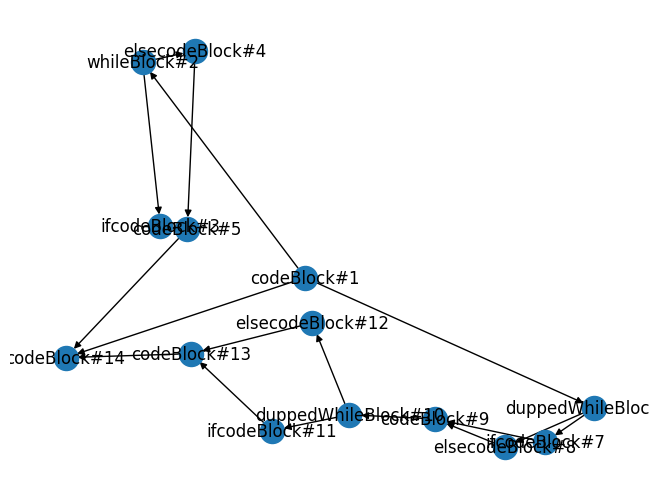

In [252]:
# # Use NetworkX's draw() function to draw the graph
debugGraph = nx.DiGraph()
debugGraph.add_edges_from([edge[:2] for edge in programGraph.edges])

print(list(programGraph.nodes))
nx.draw(debugGraph, with_labels=True)
plt.show()

# # Loop through each codeBlocks graph and draw it
# for nodeGraph in list(programGraph.nodes):
#     print(nodeGraph)
#     debugGraph = nx.DiGraph()
#     debugGraph.add_edges_from([edge[:2] for edge in nodeGraph.edges])
#     nx.draw(debugGraph, with_labels=True)
#     plt.show()

In [253]:
def get_all_program_paths(graph):
    # Helper function to find start and end node based on index
    def find_min_max(lst):
        def extract_value(s):
            return int(re.search(r'\d+', s.name).group())
        return (min(lst, key=extract_value), max(lst, key=extract_value))

    # Recursive function to find all program paths
    def get_paths(graph, start, end, path=[]):
        path = path + [start]
        if start == end:
            return [path]
        if not graph.has_node(start):
            return []
        paths = []
        for node in graph.successors(start):
            if node not in path:
                new_paths = get_paths(graph, node, end, path)
                for new_path in new_paths:
                    paths.append(new_path)
        return paths

    (start, end) = find_min_max(list(graph.nodes))

    return get_paths(graph, start, end)

def getPossibleGraphs(lst:list, counter=0) -> list:
    if isinstance(lst[0], CustomGraph):
        return_graph = CustomGraph(name=f"Final#{counter}")
        for graph in lst:  
            
            return_graph.add_edges_from(graph.edges)
        return return_graph
    if isinstance(lst[0], list):
        return [getPossibleGraphs(combination, idx) for idx, combination in enumerate(lst)] 
    
# Get all program paths
listOfCombinations = get_all_program_paths(programGraph)

# Combine the program steps within these possible paths
listOfGraphs = getPossibleGraphs(listOfCombinations)

# for combination in listOfCombinations:
#     debugGraph = nx.DiGraph()
#     plt.figure(figsize=(10,8))
#     for graph in combination:
#         debugGraph.add_edges_from([edge[:2] for edge in graph.edges])
#     nx.draw(debugGraph, with_labels=True)
#     plt.show()


In [254]:
def get_paths_down(graph: CustomGraph, start, implicit=False, path=(),visitedEdges=()):
    """
    This function traverses the graph DOWNWARDS (successors)
    :param graph: CustomGraph object
    :param start: Start node in string format
    :path: Should be left empty, only used for recusive functionality
    :visitedEdges: Should be left empty, only used for recusive functionality
    :returns: all paths from the start node DOWN the graph to all node which match the condition
    """
    path += (start,)
    if not graph.has_node(start):
        return ()
    paths = ()
    for node in graph.successors(start, implicit):
        if (start,node) not in visitedEdges:
            visitedEdges += ((start,node),)
            new_paths = get_paths_down(graph, node, implicit, path, visitedEdges)
            for new_path in new_paths:
                paths+= (new_path,)
    if not paths:
        paths += (path,)
    return paths

def get_paths_up(graph, start, condition, implicit=False):
    """
    This function traverses the graph UPWARDS (predecessors)
    :param graph: CustomGraph object
    :param start: Start node in string format
    :conition: Optional condition for nodes such that the upward traversal stops   
        (If no condition is provdied, it returns all path to the source of the graph)
    :returns: all paths from the start node UP the graph to all node which match the condition
    """
    visited = set()
    stack = [(start, [start])]
    paths = []

    while stack:
        vertex, path = stack.pop()
        if vertex not in visited:
            #if vertex[0] == "$" and len(graph.predecessors(vertex, True)) == 0:
            if condition(vertex):
                paths.append(path)
            visited.add(vertex)
            for neighbor in graph.predecessors(vertex, implicit):
                stack.append((neighbor, path + [neighbor]))
    return paths
        
def create_output_list(list_output: list, new_vulnerability: json) -> list:
    EXISTS = False
    for idx, known_vulnerability in enumerate(list_output):
        if all(known_vulnerability[key] == new_vulnerability[key] for key in ["vulnerability", "source", "sink"]):
            EXISTS = True
            if len(new_vulnerability["sanitized flows"]) == 0:
                list_output[idx]["unsanitized flows"] = "yes"
            else:
                # Check whether we habe already registered this sanitization function within this vulnerability
                if not any(vuln == new_vulnerability["sanitized flows"][0] for vuln in known_vulnerability["sanitized flows"]):
                    list_output[idx]["sanitized flows"].append(new_vulnerability["sanitized flows"][0])
    if not EXISTS:
        # Append new vulnerability to output
        list_output.append(new_vulnerability)
    return list_output

def get_sanitizers(path_from_source: list, sink, sanitize_functions):
    sanitizers = []
    for sanitize_func in sanitize_functions:
        if sanitize_func in path_from_source:
            if path_from_source.index(sanitize_func) < next((i for i in range(len(path_from_source)-1, -1, -1) if path_from_source[i] == sink), -1):
                sanitizers.append(sanitize_func)
    return sanitizers

def analyze_patterns(list_output: list, pattern: dict, graph: CustomGraph):
    # Analyze whether any source has a graph connection to any sink within the pattern
    for source in pattern["sources"]:
        # Get all possible paths downwards (sucessors) the graph from the source
        for possible_node in graph.get_possible_nodes_from_repr(source):
            possible_paths = get_paths_down(graph, possible_node, implicit=True if pattern["implicit"] == 'yes' else False)
            for sink in pattern["sinks"]:
                if sink == source:
                    continue
                for path in possible_paths:
                    # Each node is a class instance; in order to make it comparable to the strings within patterns we
                    # need to convert the class to their __repr__
                    path = [repr(i) for i in path] 
                    if sink in path:
                        sanitizers = get_sanitizers(path, sink, pattern["sanitizers"])
                        list_output = create_output_list(
                            list_output = list_output, 
                            new_vulnerability = {
                                "vulnerability": pattern["vulnerability"],
                                "source": source,
                                "sink": sink,
                                "unsanitized flows": "yes" if len(sanitizers) == 0 else "no",
                                "sanitized flows": [sanitizers] if len(sanitizers) > 0 else sanitizers
                            }
                        )
                        
    # For unitialized variables connected to sinks
    for sink in pattern["sinks"]:
        # Define the condition: Vertex needs to be a unassigned variable (no prodecessors) 
        #condition = lambda vertex: vertex[0] == "$" and len(graph.predecessors(vertex, True)) == 0
        condition = lambda vertex: isinstance(vertex, Expr_Variable) and len(graph.predecessors(vertex)) == 0
        # Get all paths upowards (predecessors) from the sink to unassigned variables (match the condition)
        for possible_node in  graph.get_possible_nodes_from_repr(sink):
            paths_from_sink = get_paths_up(graph, possible_node, condition, implicit=True if pattern["implicit"] == 'yes' else False)
            # If such path exists (i.e., if unassigned variables link to sinks)
            if len(paths_from_sink) > 0:
                for path in paths_from_sink:
                    # Reverse the path in order for get_sanitizers() to work
                    path.reverse() 
                    
                    possible_paths = get_paths_down(graph, path[0], implicit=True if pattern["implicit"] == 'yes' else False)
                    for ppath in possible_paths:
                        # Each node is a class instance; in order to make it comparable to the strings within patterns we
                        # need to convert the class to their __repr__
                        ppath = [repr(i) for i in ppath] 
                        #Because variables can be several times in the graph
                        if ppath[0] == sink:
                            continue
                        # get potential santization functions
                        sanitizers = get_sanitizers(ppath, sink, pattern["sanitizers"])
                        list_output = create_output_list(
                            list_output = list_output, 
                            new_vulnerability = {
                                "vulnerability": pattern["vulnerability"],
                                "source": ppath[0],
                                "sink": sink,
                                "unsanitized flows": "yes" if len(sanitizers) == 0 else "no",
                                "sanitized flows": [sanitizers] if len(sanitizers) > 0 else sanitizers
                            }
                        )

In [255]:
output = []
for graph in listOfGraphs:
    for pattern in patterns:
        analyze_patterns(output, pattern, graph)

with open(os.path.join('testOutputs', TEST_SlICE + '.output.json')) as json_file:
    testOutput = json.load(json_file)


print(f"{len(output)}||{len(testOutput)}")


output

3||3


[{'vulnerability': 'A',
  'source': 'd',
  'sink': 'z',
  'unsanitized flows': 'no',
  'sanitized flows': [['s']]},
 {'vulnerability': 'B',
  'source': 'b',
  'sink': '$a',
  'unsanitized flows': 'yes',
  'sanitized flows': [['s']]},
 {'vulnerability': 'B',
  'source': 'b',
  'sink': 'z',
  'unsanitized flows': 'yes',
  'sanitized flows': [['s']]}]